In [1]:
import findspark
findspark.init()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import year, month
import pyspark.sql.functions as func
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('test').config("spark.driver.memory", "15g").appName('my-cool-app').getOrCreate()


from pyspark_dist_explore import hist

from pyspark.sql.functions import year, month

In [2]:
plt.style.use("ggplot")

In [3]:
FILE = "data/generated/yt_metadata_en_urls.parquet"

schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True),  # This field must be specified as a double as it is represented as a floating point number
    StructField("urls", ArrayType(StringType()), True),
    StructField("urls_count", IntegerType(), True),
    StructField("has_urls", BooleanType(), True),
])

In [4]:
df = spark.read.parquet(FILE, schema=schema)


In [5]:
# Cast the dislike_count, like_count and view_count to their respective integer type
df = df \
    .withColumn("dislike_count", df.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", df.like_count.cast(IntegerType())) \
    .withColumn("view_count", df.view_count.cast(LongType()))\
    
    

## Total number of video containing urls

The count is $39635552$

In [6]:
df_urls = df.where(df["has_urls"] == "true")
df_urls.count()

39635552

In [7]:
df_urls.select(df_urls["dislike_count"],df_urls["like_count"], df_urls["duration"], df_urls["view_count"], df_urls["urls_count"]).summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|     dislike_count|        like_count|          duration|        view_count|        urls_count|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          38832948|          38832948|          39635552|          39635121|          39635552|
|   mean| 96.64598407517245|1794.6333588683506| 826.2556941051307|164725.98607447167|3.4811531071902317|
| stddev|3979.7913427365856| 26156.84896760549|1920.2010232393127| 4558197.649328211|4.2989266847036545|
|    min|                 0|                 0|                 1|                 0|                 1|
|    25%|                 0|                12|               152|               852|                 1|
|    50%|                 3|                73|               325|              4455|                 2|
|    75%|                18|               425|        

# Total number of video without URLs 

The count is $33289242$

In [8]:
df_no_urls = df.where(df["has_urls"] == "false")
df_no_urls.count()

33289242

In [9]:
df_no_urls.select("dislike_count","like_count", "duration", "view_count").summary().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|     dislike_count|       like_count|          duration|        view_count|
+-------+------------------+-----------------+------------------+------------------+
|  count|          32460388|         32460388|          33289242|          33289019|
|   mean| 51.50198907049417|723.1039736185531| 676.0224735967254| 78221.30427610378|
| stddev|1296.2132088331575|8448.791046188253|1689.6139066050878|1620074.6922409744|
|    min|                 0|                0|                 1|                 0|
|    25%|                 0|                4|               119|               323|
|    50%|                 1|               22|               245|              1756|
|    75%|                 7|              137|               611|             10104|
|    max|           2330721|          8073485|            360157|        1930356913|
+-------+------------------+-----------------+------------------+

# Show the number of urls video posted each month

# Group videos containing URLs by year and categories

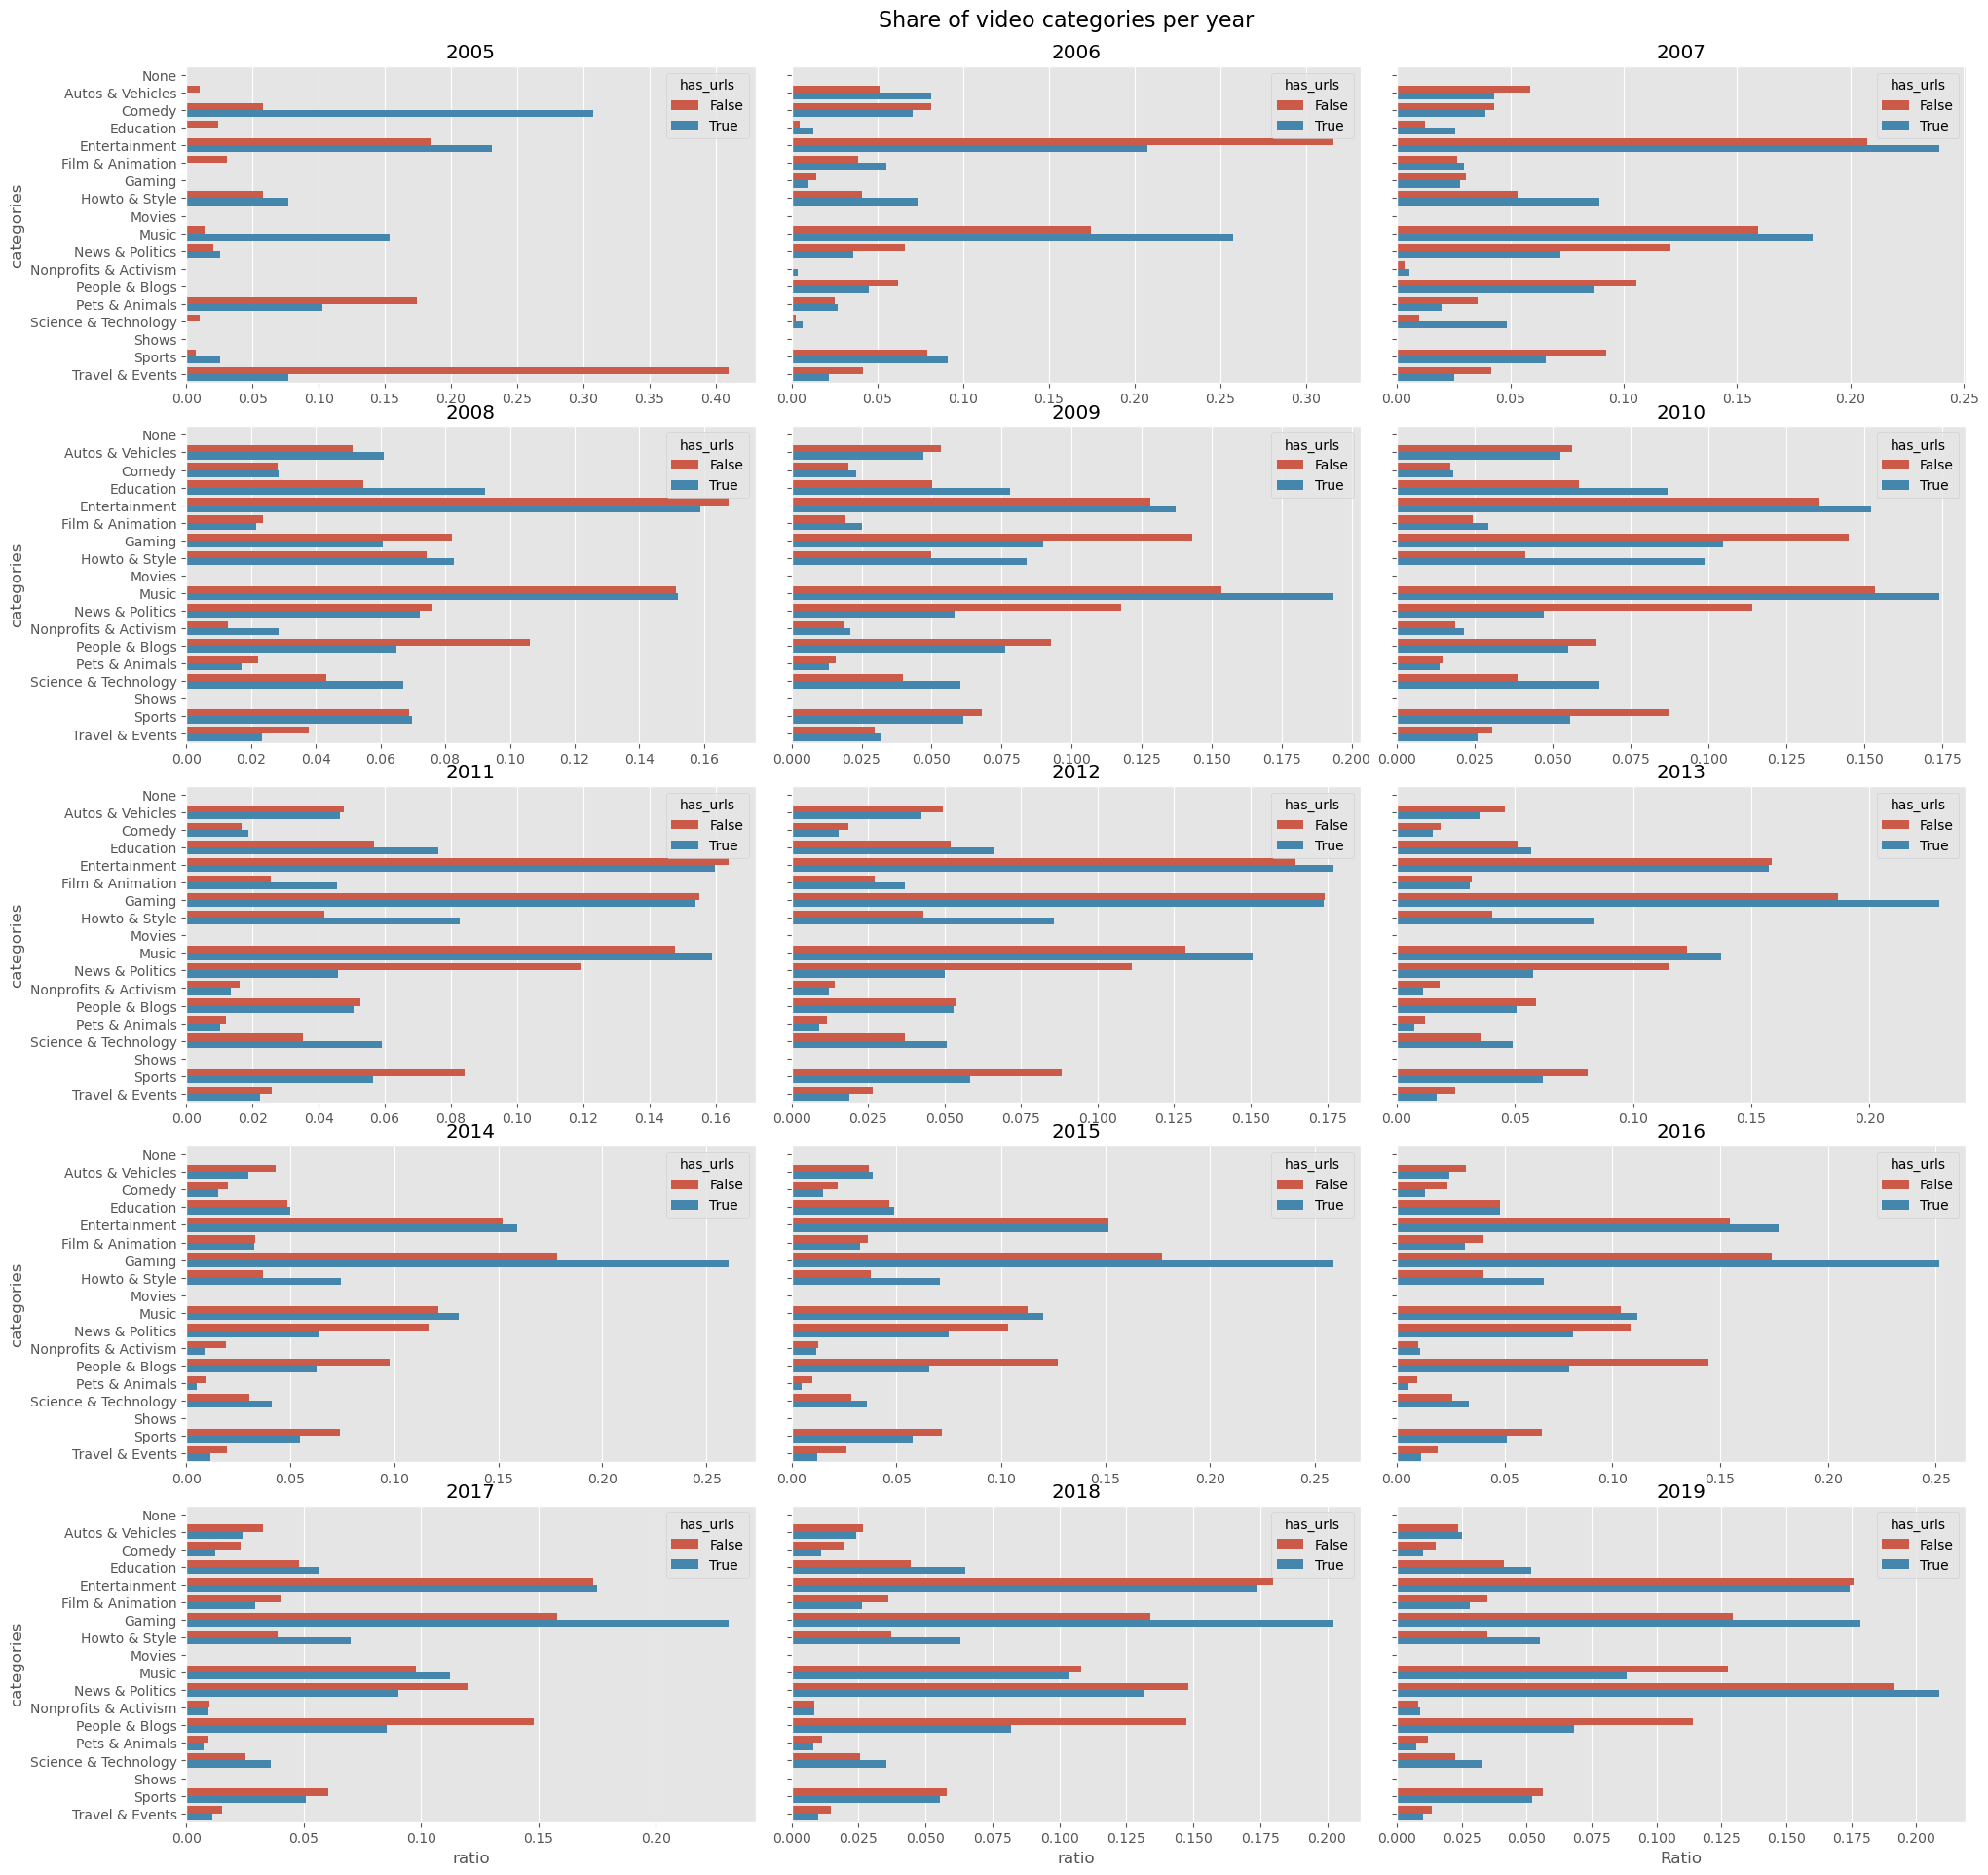

In [74]:
#Video without URLs
df_no_urls = df.where(df["has_urls"] == "false")
# Group the videos by year and month and count the number of such videos
df_dates_no_urls = df_no_urls.withColumn("year", year(df_no_urls.upload_date)).withColumn("month", month(df_no_urls.upload_date))
vids_per_month_per_cat_no_urls = df_dates_no_urls.select("display_id", "categories", "year").groupBy("year", "categories").count()
# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count_cat_no_urls = vids_per_month_per_cat_no_urls.toPandas()
count_cat_idx_no_urls = count_cat_no_urls.set_index(['year', 'categories']).unstack(fill_value=0)["count"].unstack().reset_index(name='count').reset_index().drop("index", axis=1)
vids_per_year_no_urls = count_cat_idx_no_urls.groupby(["year"])["count"].sum()
ratios_no_urls = count_cat_idx_no_urls.copy()
ratios_no_urls["ratio"] = ratios_no_urls.groupby(["year"])["count"].apply(lambda x: x / x.sum())
ratios_no_urls.categories = ratios_no_urls.categories.replace('', 'None')
ratios_no_urls["has_urls"] = False
#videos with URLs
df_urls = df.where(df["has_urls"] == "true")
# Group the videos by year and month and count the number of such videos
df_dates = df_urls.withColumn("year", year(df_urls.upload_date)).withColumn("month", month(df_urls.upload_date))
vids_per_month_per_cat = df_dates.select("display_id", "categories", "year").groupBy("year", "categories").count()
# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count_cat = vids_per_month_per_cat.toPandas()
count_cat_idx = count_cat.set_index(['year', 'categories']).unstack(fill_value=0)["count"].unstack().reset_index(name='count').reset_index().drop("index", axis=1)
vids_per_year = count_cat_idx.groupby(["year"])["count"].sum()
ratios = count_cat_idx.copy()
ratios["ratio"] = ratios.groupby(["year"])["count"].apply(lambda x: x / x.sum())
ratios.categories = ratios.categories.replace('', 'None')
ratios["has_urls"] = True

#Combine two ratios 
all_ratios = pd.concat([ratios, ratios_no_urls])


fig, axs = plt.subplots(5, 3, sharey=True, figsize=(19, 19))
fig.suptitle("Share of video categories per year", fontsize=16, y=1)

fig.tight_layout()

years = range(2005, 2020)
for ye, ax in zip(years, axs.ravel()):
    p = sns.barplot(
        ax=ax, data=all_ratios[all_ratios["year"] == ye], y="categories", x="ratio", hue = "has_urls"
    )
    
    idx = ye - 2005
    if idx % 3 != 0:
        p.set(ylabel=None)
    if idx < 12:
        p.set(xlabel=None)
    ax.set_title(ye)
    

plt.xlabel("Ratio")
plt.show()

# Group video without URLs by year and categories

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 13.0 failed 1 times, most recent failure: Lost task 9.0 in stage 13.0 (TID 232) (192.168.0.185 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more


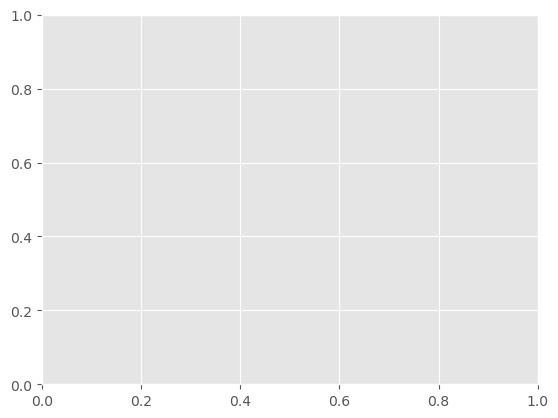

In [10]:
fig, ax = plt.subplots()
gre_histogram = df_no_urls.select('like_count').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting


# Number of URLs per video in time

In [76]:
urls_vid_per_year = df_dates.select("display_id", "year", "urls_count").groupBy("year").count()
count = urls_vid_per_year.toPandas()

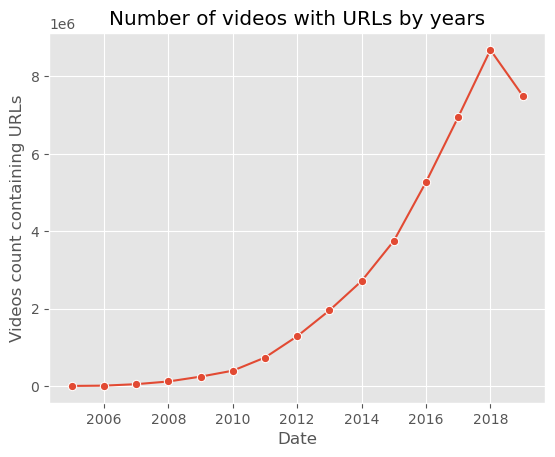

In [80]:
sns.lineplot(data=count, x="year", y="count" , marker = "o")
plt.title("Number of videos with URLs by years")
plt.xlabel("Date")
plt.ylabel("Videos count containing URLs")
plt.show()